# Overview
I will go over the following topics using the *pytorch* and *torchsample* packages:

- **Dataset Creation and Loading**
    - How you create pytorch-suitable datasets from arrays or from file in a variety of data formats, including from numpy arrays, from arbitrary data formats stored in folders, and from a list of files in a single CSV or TXT file.
- **Dataset Sampling and Feeding**
    - How you create pytorch-suitable dataset iterators and actually sample from these iterators in a variety of ways.
- **Data Transforms and Augmentation**
    - How you alter the input and/or target samples in real-time to ensure your model is robust, including how to do augmentation directly on the GPU.

This tutorial will be almost solely about Transforms.

I will be using 4 different datasets in this tutorial. They are all unique and show a different side of the process. You can skip any of the datasets if you wish - all code for each dataset will be contained to isolated code cells:
1. MNIST for 2D-Grayscale processing
2. CIFAR-10 for 2D-Color processing
3. Arrays saved in arbitrary file paths with teh file paths and labels stored in a CSV file for kaggle-like processing.
4. A Brain Image and it Segmented brain Mask for 3D-Image + Segmentation processing (NOTE: requires the *nilearn* package).


## Understanding `Datasets`, `DataLoaders`, and `Transforms` in Pytorch

When it comes to loading and feeding data in pytorch, there are three main concepts: Datasets, DataLoaders, and Transforms.

**Transforms** are small classes which take in one or more arrays, perform some operation, then return the altered version of the array(s). They almost always belong to a `Dataset` which carries out those transforms, but can belong to more than one dataset or can actually stand on their own. This is where a lot of the custom user-specific code happens. Thankfully, `Transforms` are very easy to build as I will show soon.

**Datasets** actually *store* your data arrays, or the filepaths to your data if loading from file. If you can load your data completely into memory - such as with MNIST - you should use the `TensorDataset` class. If you **cant** load your complete data into memory - such as with Imagenet - you should use the `FolderDataset`. I will describe these later, including how to create your own dataset (the `CSVDataset` class to load from a csv)

**DataLoaders** are used to actually *sample* and *iter* through your data. This is where all the multi-processing magic happens to load your data in multiple threads and avoid starving your model. A `DataLoader` **always** takes a `Dataset` as input (this is object composition), along with a few other parameters such as the batch size. You will basically *NEVER* need to alter the DataLoaders - just use the built-in ones.

The order in which I presented these topics above are usually the order in which you will create the objects! First, make your transforms. Next, make your `Dataset` and pass in the transforms. Next, make your `DataLoader` and pass in your `Dataset`.

Here is a small pseudo-code example of the process:

```python
# Create the transforms
my_transform = Compose([SomeTransform(), SomeOtherTransform()])
# Create the dataset - pass in your arrays and the transforms
my_dataset = Dataset(x_array, y_array, transform=my_transform)
# Create the Dataloader - pass in your dataset and some other args
my_loader = DataLoader(my_dataset, batch_size=32)

# Iterate through the loader
for x, y in my_loader:
    do_something(x, y)
```

# 0. Loading our test data


In [1]:
# some imports we will need
import os
import matplotlib.pyplot as plt

import torch as th
from torchvision import datasets

### 0a. Load MNIST
MNIST is a collection of 28x28 images of Digits between 0-9, with 60k training images and 10k testing images. The images are grayscale, so there is only a single channel dimension (1x28x28)

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


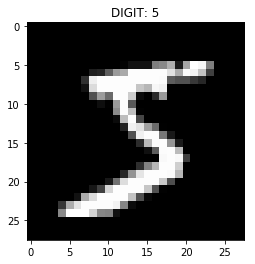

In [2]:
# Change this to where you want to save the data
SAVE_DIR = os.path.expanduser('~/desktop/data/MNIST/')
# train data
mnist_train = datasets.MNIST(SAVE_DIR, train=True, download=True)
x_train_mnist, y_train_mnist = mnist_train.train_data.type(th.FloatTensor), mnist_train.train_labels
# test data
mnist_test = datasets.MNIST(SAVE_DIR, train=False, download=True)
x_test_mnist, y_test_mnist = mnist_test.test_data.type(th.FloatTensor), mnist_test.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.show()

### 0b. CIFAR-10
CIFAR10 is an image recognition dataset, with images of 3x98x98 size.

Files already downloaded and verified
Files already downloaded and verified
Training Data Size:  (50000, 32, 32, 3) - (50000,)
Testing Data Size:  (10000, 32, 32, 3) - (10000,)


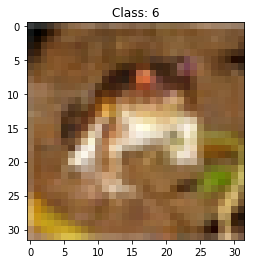

In [3]:
import numpy as np
# Change this to where you want to save the data
SAVE_DIR = os.path.expanduser('~/desktop/data/CIFAR/')
# train data
cifar_train = datasets.CIFAR10(SAVE_DIR, train=True, download=True)
x_train_cifar, y_train_cifar = cifar_train.train_data, np.array(cifar_train.train_labels)
# test data
cifar_test = datasets.CIFAR10(SAVE_DIR, train=False, download=True)
x_test_cifar, y_test_cifar = cifar_test.test_data, np.array(cifar_test.test_labels)

print('Training Data Size: ' ,x_train_cifar.shape, '-', y_train_cifar.shape)
print('Testing Data Size: ' ,x_test_cifar.shape, '-', y_test_cifar.shape)

plt.imshow(x_train_cifar[0], cmap='gray')
plt.title('Class: %i' % y_train_cifar[0])
plt.show()

### 0c. A CSV File of arbitrary Filepaths to 2D arrays

For the third dataset, I will create some random 2D arrays and save them to disk without any real order. I will then write the file-paths to each of these images to a CSV file and create a dataset from that CSV file. This is a common feature request in the pytorch community, I think because many Kaggle competitions and the like provide input data in this format.

Here, I will just generate a random string for each of the file names to show just how arbitrary this is.

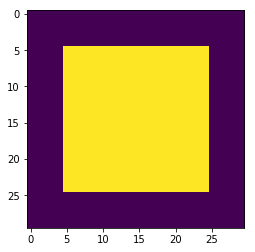

                                        files  labels
0  /Users/ncullen/desktop/data/CSV/YZL2M7.npy       0
1  /Users/ncullen/desktop/data/CSV/XHAAGV.npy       1
2  /Users/ncullen/desktop/data/CSV/0ZZRST.npy       2
3  /Users/ncullen/desktop/data/CSV/DWKH5L.npy       3
4  /Users/ncullen/desktop/data/CSV/0IHOQ6.npy       4


In [4]:
import numpy as np
import pandas as pd
import os
import random
import string
# create data
X = np.zeros((10,1,30,30))
for i in range(10):
    X[i,:,5:25,5:25] = i+1
Y = [i for i in range(10)]

plt.imshow(X[0,0,:,:])
plt.show()

# save to file
SAVE_DIR = os.path.expanduser('~/desktop/data/CSV/')
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)
else:
    import shutil
    shutil.rmtree(SAVE_DIR)
    os.mkdir(SAVE_DIR)
paths = []
for x in X:
    
    file_path = os.path.join(SAVE_DIR,''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(6))
)
    #print(file_path+'.npy')
    np.save('%s.npy' % file_path, x)
    paths.append(file_path+'.npy')

# create data frame from file paths and labels
df = pd.DataFrame(data={'files':paths, 'labels':Y})
print(df.head())

# save data frame as CSV file
df.to_csv(os.path.join(SAVE_DIR, '_DATA.csv'), index=False)

### 0d. 3D Brain Images

Finally, I'll grab a standard structural MRI scan and the brain binary mask from the *nilearn* package to show how the processing you can do with 3D images using *pytorch* and *torchsample*. The MRI scan will include the skull and head, and the mask will be for just the brain. This is a common task in processing neuroimages -- to segment just the brain from the head.

This data will also be useful to show the processing step involved when **BOTH** the input and target tensors are images.

Image Sizes:  (197, 233, 189) , (197, 233, 189)


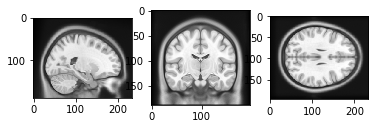

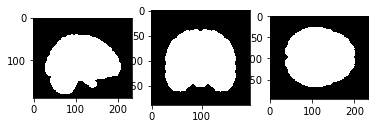

In [5]:
import nilearn.datasets as nidata
import nibabel as nib
icbm = nidata.fetch_icbm152_2009()
#print(icbm.keys())
t1 = nib.load(icbm['t1']).get_data()
mask = nib.load(icbm['mask']).get_data()
print('Image Sizes: ' , t1.shape, ',' , mask.shape)
plt.figure(1)
plt.subplot(131)
plt.imshow(t1[120,:,:].T[::-1], cmap='gray')
plt.subplot(132)
plt.imshow(t1[:,120,:].T[::-1],cmap='gray')
plt.subplot(133)
plt.imshow(t1[:,:,100],cmap='gray')
plt.show()

plt.figure(2)
plt.subplot(131)
plt.imshow(mask[120,:,:].T[::-1], cmap='gray')
plt.subplot(132)
plt.imshow(mask[:,120,:].T[::-1],cmap='gray')
plt.subplot(133)
plt.imshow(mask[:,:,100],cmap='gray')
plt.show()


# 2. Creating a Pytorch-compatible Dataset

Now that we have our transforms, we will create a Dataset for them!

There are three main datasets in *torchsample* : 
- `torchsample.TensorDataset`
- `torchsample.FolderDataset`
- `torchsample.FileDataset`

The first two are extensions of the *pytorch* equivalent classes: 
- `torch.utils.data.TensorDataset`
- `torch.utils.data.FolderDataset`

The last one (`torchsample.FileDataset`) is unique to *torchsample*, and allows you to read data from a CSV file containing a list of arbitrary filepaths to data.

You should feel free to use the official classes instead if you don't need the extra functionality, but there is really no difference between them internally. Also, you may find that you actually need the *torchsample* versions of these classes to do many of the transforms presented below.

The extra functionality in the *torchsample* versions includes the following:
- support for target transforms
- support for co-transforms (same transform applied to both input and target)

# 1. Creating Transforms

Now that we have our tutorial datasets stored in files or in memory, we will create our transforms! Transforms generally are classes and have the following structure:

```python
class MyTransform(object):

    def __init__(self, some_args):
        self.some_args = some_args
       
    def __call__(self, x):
        x_transform = do_something(x, self.some_args)
        return x_transform
```

So you see any arguments for the transform should be passed into the initializer, then the transform should implement the `__call__` function. You simply instantiate the transform class then use the transform exactly as you would use a function, with your array to be transformed as the function argument. Here's some pseudo-code for how to use a transform:

```python
tform = MyTransform(some_args=some_value)
x_transformed = tform(x)
```

It's also important to note that **TRANSFORMS ACT ON INDIVIDUAL SAMPLES - NOT BATCHES**. Therefore, if you have a dataset of size (10000, 1, 32, 32) then your transform's `__call__` function should assume it only receives individual samples of size (1, 32, 32). There **will be no sample dimension**.



## 1a. Creating Transforms for MNIST

Here, I will create some transforms for MNIST. I will use the following transforms, available in the *torchsample* package:

- AddChannel
- RangeNormalize
- RandomCrop
- RandomRotate


If you remember, the MNIST data was of size (60000, 28, 28). We will need to add a channel dimension, so we will use the `AddChannel` transform to add a channel to the first dimension. 

In [6]:
from torchsample.transforms import AddChannel
# add channel to 0th dim - remember the transform will only get individual samples
add_channel = AddChannel(axis=0)

Because our MNIST is already in-memory, we can actually test the transform on one of the images. Note, however, that we couldn't do this if we were loading data from file.


In [7]:
print('Before Tform: ' , x_train_mnist[0].size())
x_with_channel = add_channel(x_train_mnist[0])
print('After Tform: ' , x_with_channel.size())

Before Tform:  torch.Size([28, 28])
After Tform:  torch.Size([1, 28, 28])


Now, it would be kind of wasteful to have to add a channel every time we draw a sample. In reality, we would just do this transform once on the entire dataset since it's already in memory:

```python
x_train_mnist = AddChannel(axis=0)(x_train_mnist)
```

Next, we know that the MNIST data is valued between 0 and 255, so we will use the `RangeNormalize` transform to normalize the data between 0 and 1. We will pass in the min and max value of the normalized range, along with the values for `fixed_min` and `fixed_max` since we already know that value so the transform doesnt have to calculate the min and max each sample.

In [8]:
from torchsample.transforms import RangeNormalize
norm_01 = RangeNormalize(0, 1)

Again, we can test this:

In [9]:
print('Before Tform: ' , x_train_mnist[0].min(), ' - ', x_train_mnist[0].max())
x_norm = norm_01(x_train_mnist[0])
print('After Tform: ' , x_norm.min(), ' - ', x_norm.max())

Before Tform:  0.0  -  255.0
After Tform:  0.0  -  1.0


Next, we will add a transform to randomly crop the MNIST image. Suppose our network takes in images of size (1, 20, 20), then we will randomly crop our (1, 28, 28) images to this size:

In [10]:
from torchsample.transforms import RandomCrop
# note that we DONT add the channel dim to transform - the same crop will be applied to each channel
rand_crop = RandomCrop((20,20))

Before TFORM:  torch.Size([1, 28, 28])
After TFORM:  torch.Size([1, 20, 20])


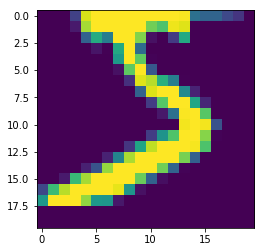

In [11]:
x_example = add_channel(x_train_mnist[0])
print('Before TFORM: ' , x_example.size())
x_crop = rand_crop(x_example)
print('After TFORM: ' , x_crop.size())
plt.imshow(x_crop[0].numpy())
plt.show()

Finally, we will add a `RandomRotate` transform from the *torchsample* package to randomly rotate the image some number of degrees:

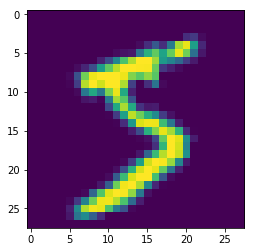

In [12]:
from torchsample.transforms import RandomRotate
x_example = add_channel(x_train_mnist[0])
rotation = RandomRotate(30)
x_rotated = rotation(x_example)
plt.imshow(x_rotated[0].numpy())
plt.show()

Now, we will chain all of these above transforms into a single pipeline using the `Compose` class. This class is necessary for `Datasets` because they only take in a single transform. You can chain multiple `Compose` classes if you want.

In [13]:
from torchsample.transforms import Compose
tform_chain = Compose([add_channel, norm_01, rand_crop, rotation])

Now let's test the entire pipeline:

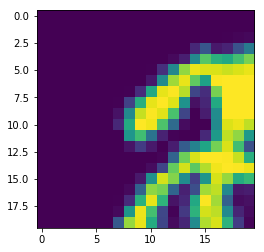

In [14]:
x_example = x_train_mnist[5]
x_tformed = tform_chain(x_example)
plt.imshow(x_tformed[0].numpy())
plt.show()

There you have it - an MNIST digit for which we 1) added a channel dimension, 2) normalized between 0-1, 3) made a random 20x20 crop, then 4) randomly rotated between -30 and 30 degrees.

## 1b. Creating Transforms for CIFAR-10

Here, I will create some transforms for CIFAR-10. Remember, this data is 2D color images so there will be 3 channel dimensions. Because we have color images, we can use a lot of cool image transforms to mess with the color, saturation, I will use the following transforms, available in the *torchsample* package:

- ToTensor
- TypeCast
- RangeNormalize
- RandomAdjustGamma
- AdjustBrightness
- RandomAdjustSaturation

You'll note that one of the transforms `AdjustBrightness` doesn't have "Random" in front of it. Just like with the `Affine` transforms, you can either specify a specific value for the transform or simply specific a range from which a uniform random selection will be made.

First, you'll note that the CIFAR data was in NUMPY format. All of these transforms I'm showing only work on torch tensors. For that reason, we will first use the `ToTensor` transform to convert the data into a torch tensor. Again, it might be best to simply do this on the entire dataset as a pre-processing step instead of during real-time sampling.

In [15]:
from torchsample.transforms import ToTensor

x_cifar_tensor = ToTensor()(x_train_cifar[0])
print(type(x_cifar_tensor))

<class 'torch.ByteTensor'>


Oh No.. This data is still in `ByteTensor` format! We should be smart and simply cast the entire dataset to `torch.FloatTensor`, but for the sake of demonstration let's use the `TypeCast` transform:

In [16]:
from torchsample.transforms import TypeCast

x_cifar_tensor = TypeCast('float')(x_cifar_tensor)
print(type(x_cifar_tensor))

<class 'torch.FloatTensor'>


Great! Now, we will perform some actual image transforms. But first, we should `RangeNormalize` because these transforms assume the image is valued between 0 and 1:

In [17]:
print(x_cifar_tensor.min() , ' - ' , x_cifar_tensor.max())
x_cifar_tensor = RangeNormalize(0,1)(x_cifar_tensor)
print(x_cifar_tensor.min() , ' - ' , x_cifar_tensor.max())

0.0  -  255.0
0.0  -  1.0


For the `RandomAdjustGamma` transform, a value less than 1 will tend to make the image lighter, and a value greater than 1 will tend to make the image lighter. Therefore, we will make our range between 0.5 and 1.5.

In [18]:
from torchsample.transforms import RandomAdjustGamma, AdjustGamma

gamma_tform = RandomAdjustGamma(0.2,1.8)
x_cifar_gamma = gamma_tform(x_cifar_tensor)

Ok, now let's plot the difference:

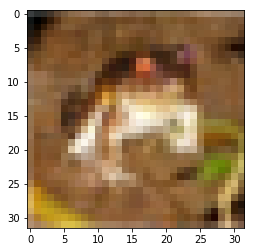

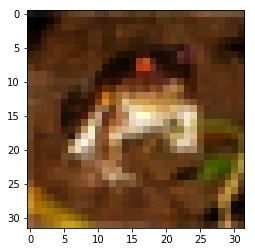

In [19]:
plt.imshow(x_train_cifar[0])
plt.show()
plt.imshow(x_cifar_gamma.numpy())
plt.show()

Cool, the sampled Gamma value was greater than 1, so the image became a little darker. It's important to note that the gamma value will be randomly sampled **every time you call the transform**. This means every sample will be different. This is a good transform to make your classifier robust to different inputs. Let's do the other transforms:

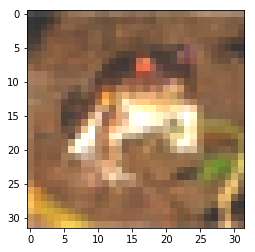

In [20]:
from torchsample.transforms import AdjustBrightness

# make our image a little brighter
bright_tform = AdjustBrightness(0.2)
x_cifar_bright = bright_tform(x_cifar_gamma)

plt.imshow(x_cifar_bright.numpy())
plt.show()

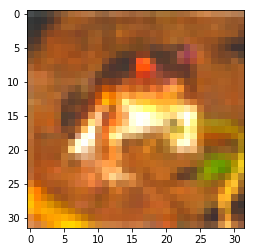

In [21]:
from torchsample.transforms import RandomAdjustSaturation, ChannelsFirst, ChannelsLast
sat_tform = RandomAdjustSaturation(0.5,0.9)
x_cifar_sat = sat_tform(ChannelsFirst()(x_cifar_bright))

plt.imshow(ChannelsLast()(x_cifar_sat).numpy())
plt.show()

Now the image is a little more saturated. However, you'll notice we had to do a little trick. The *pytorch* and *torchsample* packages assume the tensors are in CHW format - that is, the channels are first. Our CIFAR data was naturally in HWC format, which Matplotlib likes. Therefore, we had to do the `ChannelsFirst` transform then the `ChannelsLast` format to go between the two. We will add the `ChannelsFirst` transform to our pipeline, although it might be best to do that first!

Let's make our final pipeline for cifar:

In [22]:
cifar_compose = Compose([ToTensor(), 
                         TypeCast('float'), 
                         ChannelsFirst(),
                         RangeNormalize(0,1),
                         RandomAdjustGamma(0.2,1.8),
                         AdjustBrightness(0.2),
                         RandomAdjustSaturation(0.5,0.9)])

Again, let's test this on a single example to make sure it works:

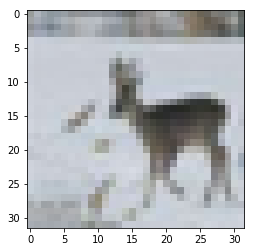

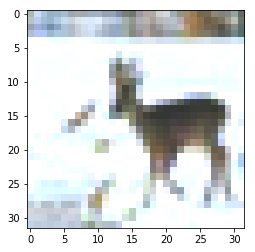

In [23]:
x_cifar_example = x_train_cifar[20]
x_cifar_tformed = cifar_compose(x_cifar_example)

plt.imshow(x_cifar_example)
plt.show()
plt.imshow(ChannelsLast()(x_cifar_tformed).numpy())
plt.show()

So Awesome!

We will skip transforms for the data saved to random image files, because the point of that data is to show how to make a custom `Dataset` which will be in the next section.

## Transforms for the Segmentation Data
For the 3D brain images, we had a brain image and its segmentation. I will quickly show now how you can perform the same transform on both input and target images. It's pretty simple.

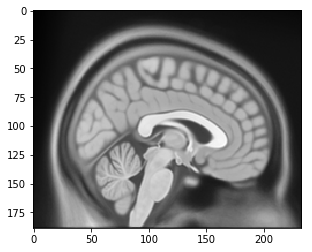

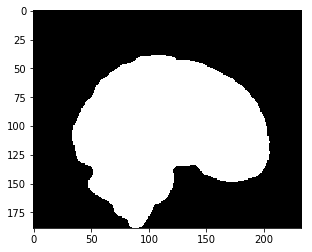

In [24]:
# grab a 2D slice from the data
t1_slice = np.expand_dims(t1[100,:,:],0)
mask_slice = np.expand_dims(mask[100,:,:],0)
plt.imshow(t1_slice[0].T[::-1], cmap='gray')
plt.show()
plt.imshow(mask_slice[0].T[::-1],cmap='gray')
plt.show()

Ok, now let's do a random `Affine` transform and show how it correctly performs the same transform on both images:

In [27]:
from torchsample.transforms import RandomAffine

t1_slice, mask_slice = TypeCast('float')(*ToTensor()(t1_slice, mask_slice))

tform = RandomAffine(rotation_range=30, translation_range=0.2, zoom_range=(0.8,1.2))
t1_slice_tform, mask_slice_tform = tform(t1_slice, mask_slice)

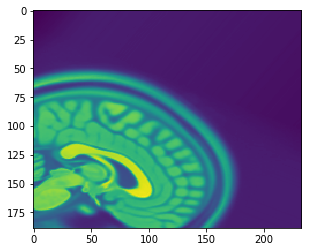

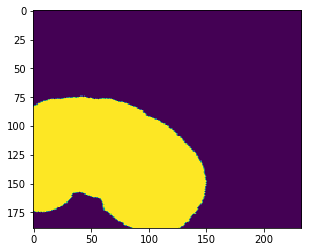

In [31]:
plt.imshow(t1_slice_tform[0].numpy().T[::-1])
plt.show()
plt.imshow(mask_slice_tform[0].numpy().T[::-1])
plt.show()

Clearly, the random affine transform was correctly preserved between the two images. This is great news for segmentation datasets.

In the next tutorial, I will move on to `Datasets` and `DataLoaders`.